# RepMet usecase:  Automatic recognition of food items on a cafeteria tray

## Introduction 

A service, currently provided in some of the self-service cafeterias in Europe, is an expedited checkout process performed by placing the tray with food items in a small kiosk equipped with few cameras to capture its content. The cashier can now produce the check out offline, using the photographs of the tray.

IBM Research have developed a solution which automates this process, performing detection of the food items in the images of the trays and providing the cashier with the list of items to bill. The technology it is based on is the RepMet few-shot detection engine. The solution was developed for JES (a large European company providing solutions for restaurants and food franchises), and is now in the advanced stage of deployment.  



The following code sets up the environment and prints a typical image data acquired for one tray from an array of three cameras, placed above it in fixed positions:

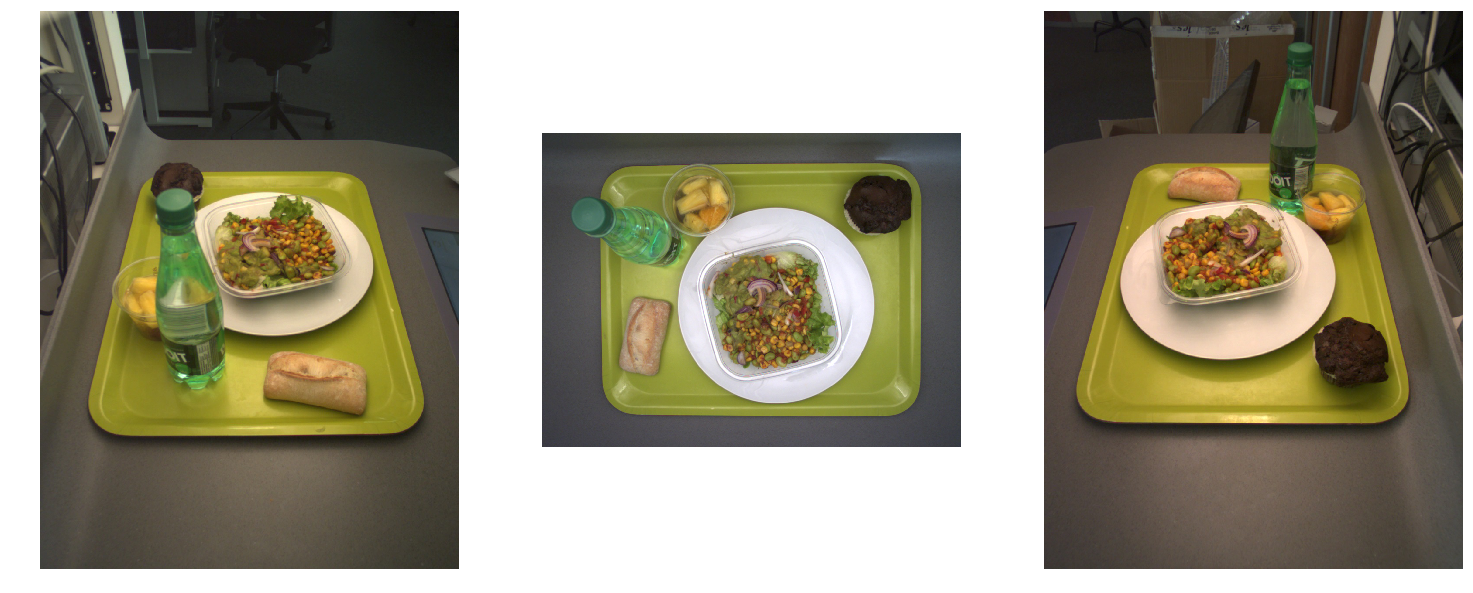

In [1]:
%run -i 'notebook_startup.py'
%matplotlib inline
from food_usecase_routines import print_typical_tray_multiview
print_typical_tray_multiview()

The difficulty of recognition of food items on trays may range from a very easy to a very difficult task. Packaged food, which has exactly the same appearance both in training and the query images, is most easily recognized. Other food items may have variance in their appearance – fruits, bread buns, deserts, main dishes. The appearance of a dish may be drastically changed by an added dressing, or by mixing some food on the plate. 

Furthermore, the restaurant’s menu changes daily, and for several food items, their visual appearance only becomes available in the morning, half an hour before the service is expected to operate, hence with only a few examples for each daily item. This is where the few-shot capability of the RepMet detector comes handy: an enrollment procedure, which takes up to 10 min of the computer time, incorporates the new few examples in the detector, enabling their recognition alongside the permanent items.
    
In this interactive usecase notebook, we provide the necessary code to execute food detection on query images of the trays, perform enrollment of new dishes into the system, and consequently perform the detection of both permanent and new dishes. The code is supported by the RepMet object detection system, available in the GitHub repository <url>. Its output is presented currently in the notebook, and it can be reconstructed by running the notebook once the necessary environment installation is performed.


### RepMet system setup

In [3]:
args.scfg_fname = '../experiments/serv_configs/csfg_food_usecase_01.yaml'
args.scfg_args = 'NA'
args.gpu = 0 # the GPU ordinal on multti-GPU machine
fs_serv = FSD_serv(args)  # create the FSD service object 
fs_serv.setup()  # setup detection engine, classes list, set up aug.generator, logger, performance evaluator


2019-09-22 03:12:38,374 - my_logger - INFO -  ========= starting FSD service csfg_food_usecase_01


{'gpu': 0, 'scfg_fname': '../experiments/serv_configs/csfg_food_usecase_01.yaml', 'scfg_args': 'NA'}


2019-09-22 03:12:38,723 - my_logger - INFO - Loading a trained model ./output/FSD_service/csfg_food_usecase_01/the_novl_model-0000.params
2019-09-22 03:12:38,878 - my_logger - INFO - Novel products model is loaded
2019-09-22 03:12:38,880 - my_logger - INFO - No container model is loaded
2019-09-22 03:12:38,881 - my_logger - INFO - No alternative model is loaded


### RepMet as a standard detector

The following code exemplifies the basic usage of the detector for permanent food items:

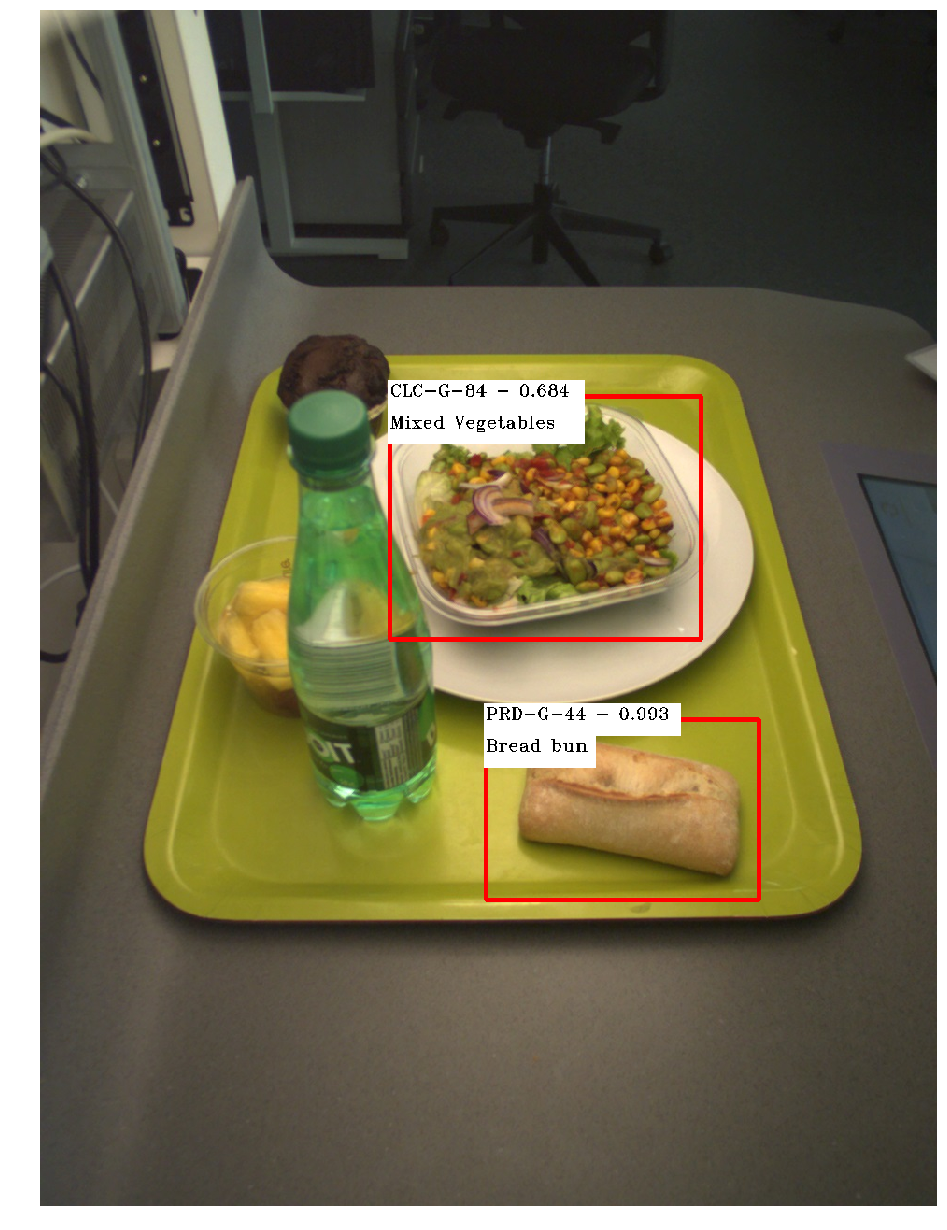

In [11]:
from food_usecase_routines import test_on_query_image
#test_img_fname = '../data/Food/food_usecase_data/1007_10000000006716_left.jpg'
test_img_fname = '../data/Food/food_usecase_data/15849_left.jpg'
det_engines = 1
test_on_query_image(fs_serv,test_img_fname,det_engines) 

## Few-shot detection for daily items

Daily enrollment of the new food items consists of providing 3-5 image triplets (left, top, right) for each new such item. The images contain a tray containing the item, annotated by a bounding box with the corresponding new class label. 
The introduction of a new class example to RepMet consists of two stages:
 - Compute the feature vector, representing the image region with the food item, and use it as the representative of the new class
 - When all the representatives are in place, (optionally) perform partial* finetuning of the model, adjusting it to the new classes.
The detection of the few-shot classes is performed on a separate instance of the model, where no previous (permanent) object categories are present. Those are detected with the original version of the model, trained in the standard fashion, and the results are fused in the later stage.
 
_* the finetuning is performed only for the few last layers of the network_

the following code exemplifies the enrollment process and test on the images containing daily items


### examples of new, few-shot food classes:

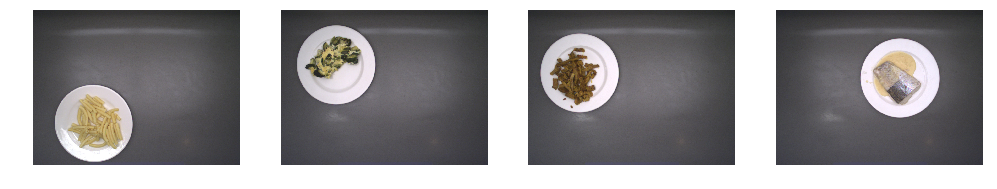

In [4]:
from food_usecase_routines import display_few_shot_examples
display_few_shot_examples()

### enrollment of daily foods into the detector:

In [15]:
#zip_path = '../data/Food/20190604/data_enrolment_20190604_112921.zip'
zip_path = '../data/Food/food_usecase_data/data_enrolment_20190604_161059.zip'
novel_train_type = 1 # types: 0 - no finetuning, 1 - fast fine-tuning, 2 - full fine-tuning
fs_serv.train_novel_classes(zip_path, novel_train_type, num_scenes=3, train_stop_event=None)

2019-09-22 03:02:46,348 - my_logger - DEBUG - Starting novel class training using ../data/Food/food_usecase_data/data_enrolment_20190604_161059.zip.
2019-09-22 03:02:46,626 - my_logger - INFO - train_novel_classes: using path names with root ./output/FSD_service/csfg_food_usecase_01/novel_images/PRDS990000000000000921_0_243_422_704_780_left.jpg
2019-09-22 03:02:46,628 - my_logger - INFO - - running train_model with novel_train_type=1


gen_train_data: using folder ./output/FSD_service/csfg_food_usecase_01/novel_images


2019-09-22 03:03:11,358 - my_logger - INFO - No rois found for training box of PRD-S-990000000000000965


Box #0 - no overlapping detection boxes found


2019-09-22 03:03:18,468 - my_logger - INFO - No rois found for training box of PRD-S-990000000000000965


Box #0 - no overlapping detection boxes found


2019-09-22 03:03:19,663 - my_logger - INFO - No rois found for training box of PRD-S-990000000000000965
2019-09-22 03:03:19,725 - my_logger - INFO - Introducing novel classes to the model
2019-09-22 03:03:19,727 - my_logger - INFO - Generating reps. Class PRD-S-990000000000000965: 6 good samples, 3 bad samples
2019-09-22 03:03:19,728 - my_logger - INFO - Generating reps. Class PRD-S-990000000000000964: 9 good samples, 0 bad samples
2019-09-22 03:03:19,730 - my_logger - INFO - Generating reps. Class PRD-S-990000000000000921: 9 good samples, 0 bad samples
2019-09-22 03:03:19,749 - my_logger - INFO - Performing fine-tuning


Box #0 - no overlapping detection boxes found
total size 27
total size 27
total size 27
-------- training epoch 0 ---------------


2019-09-22 03:04:30,054 - my_logger - INFO - Epoch[0] Train-R-CNN FG Accuracy=0.963107
2019-09-22 03:04:30,059 - my_logger - INFO - Epoch[0] Train-RCNNAcc=0.973307
2019-09-22 03:04:30,060 - my_logger - INFO - Epoch[0] Train-RCNNLogLoss=0.154303
2019-09-22 03:04:30,062 - my_logger - INFO - Epoch[0] Train-RCNNL1Loss=0.073217
2019-09-22 03:04:30,064 - my_logger - INFO - Epoch[0] Time cost=1.712


total size 27
precomputed_training: 70.3290379047 sec


2019-09-22 03:04:30,810 - my_logger - INFO - Loading a trained model ./output/FSD_service/csfg_food_usecase_01/the_novl_model-0000.params


### test on a query image
The permanent foods are detected as red boxes, the new few-shot foods are marked as green boxes

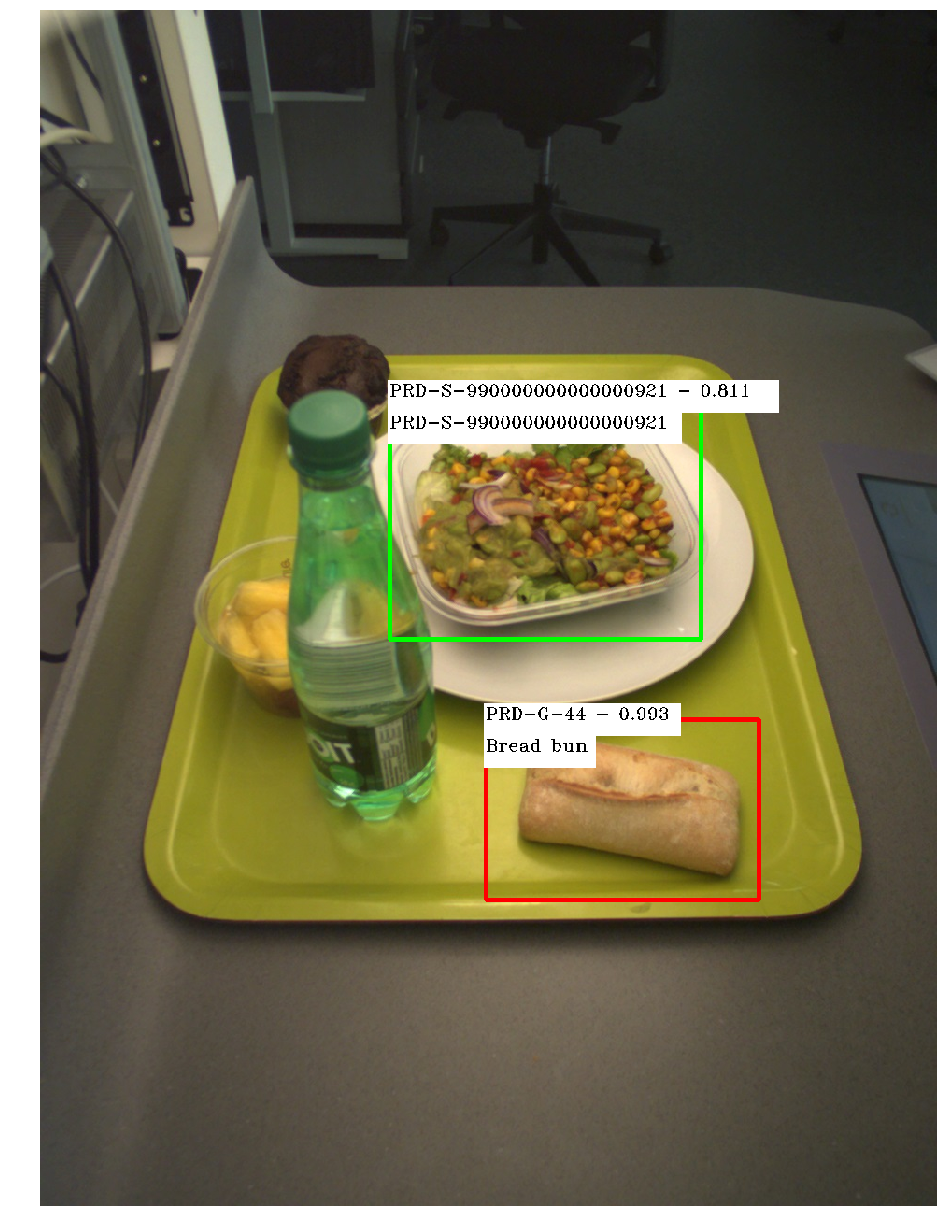

In [16]:
#test_img_fname = '../data/Food/food_usecase_data/1007_10000000017004_left.jpg'
test_img_fname = '../data/Food/food_usecase_data/15849_left.jpg'
det_engines = 3
test_on_query_image(fs_serv,test_img_fname,det_engines)    

As a recent extension, an algorithm for automatic bounding box prediction on a tray with unseen item was developed, thus reducing the human workload in the enrollment stage. The algorithm exploits the fact the Region Proposal Network (RPN) of the object detector is learned to produce food item regions, agnostic to their specific class. Trained on other (permanent) items, it works well also on those previously unseen. The ability to predict boxes for instance of new objects has a good potential to generalize to other types of visual categories and other usecases. Thus, the human workload is reduced not only with respect to number of required samples, but also in the effort required to produce their annotations.

In the following code snippet, the bounding box estimate is performed on image taken for enrollment of daily foods. The displayed food category is irrelevant in this case.

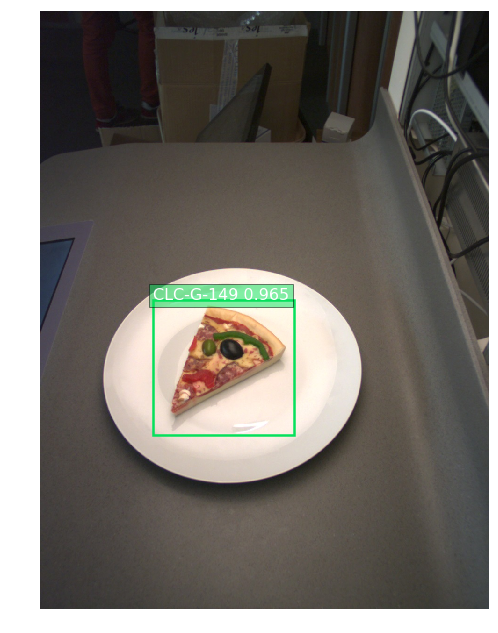

In [4]:
#img_path = '../data/Food/food_usecase_data/PRDS990000000000000201_0_395_678_719_995_right.jpg'
img_path = '../data/Food/food_usecase_data/PRD-G-1861_242_603_565_896_Right.jpg'

from food_usecase_routines import get_box_proposal
get_box_proposal(fs_serv,img_path)

## Quantitative performance evaluation
The RepMet engine operates in this usecase in two modes: as a standard detector for permanent items, pretrained on relatively large annotated data, and as a few-shot detector for the daily dishes. The measured performance in the project pilot is as follows.
### Permanent foods – standard detection regime
In the pilot phase, 143 different food items were annotated with ~100 bounding boxes per each (counting the different views of the same item). Detector performance stands on 91.8% Average Precision (AP).
### Daily foods – few-shot regime
In daily enrollments, 6-8 food items with 3 samples each (3 trays X 3 views) were used as the few-shot episide data. Average AP value, obtained from food trays analyzed later during the day, stands on 86.7%
